# Problem Description & Introduction

This dataset comes from a kaggle competition whereby users are chalenged to come up with a novel algorithim that clasiffies various sets of images of cells as cancerous or non-cancerous. It is a set of real data showing images from digital pathology scans. The goal of this project is to take this data and develop an algorithm, utilizing Convolutional Neural Network (CNN), that will run through them images and identify them as metastatic cancer or not metastatic cancer. Auccuracy and AUC scores will be used to validate the efficacy of the model, and show how accuracte it is at identifying cancer. In this notebook, two models are created (Model 1- a baseline experiment and then Model 2- a hyperparameter tuned version with cleaner architecture).

The workflow of this project will be as follows: 1. Performing EDA and data preparation for modeling, 2. Building a baseline Model (Model 1), 3. Improving upon that model (Model 2) with improved architecture, hyperparameter tuning, and better training, 4. Evaluating the results, and 5. Selecting the best model for submission.

# Library Import

Importing all necesary libraries required for this project

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import BinaryAccuracy, AUC
from tensorflow.keras import callbacks
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img

# Data Load and Ingestion

Utilizing google colab for this project, I uploaded the data to my google drive, and then extracted it below as it is initially in a zip file. If attempting to run this notebook, I would suggest using A100 or T4 GPU, when modeling.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p data
!unzip '/content/drive/MyDrive/CNNDetection/histopathologic-cancer-detection.zip' -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: data/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: data/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: data/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: data/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: data/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: data/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: data/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: data/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: data/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: data/train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: data/train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: data/train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: data/train/fa

In [4]:
!ls data

sample_submission.csv  test  train  train_labels.csv


# EDA/Data Inspection

Below I am performing some basic data inspection and EDA. This is an important step in undestanding the structure of the data, the label distribution, and visually understanding what the images look like.

First I am simply printing the total image count for the train and test set, and then viewing the data-head to understand how it is structured.

In [5]:
print('Train Image Count is ' , len(os.listdir('data/train')))
print('Test Image Count is ' , len(os.listdir('data/test')))

print('\nTrain Label length and width is ', pd.read_csv('data/train_labels.csv').shape)

df_label = pd.read_csv('data/train_labels.csv')
print(df_label.head())

Train Image Count is  220025
Test Image Count is  57458

Train Label length and width is  (220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


The bar chart below is simply an inspection of overall data balance to identify how much of the data set is labeled as malignant vs benign. It looks as though there is a slight imbalance, but nothing too far-fetched that it would throw off the analysis

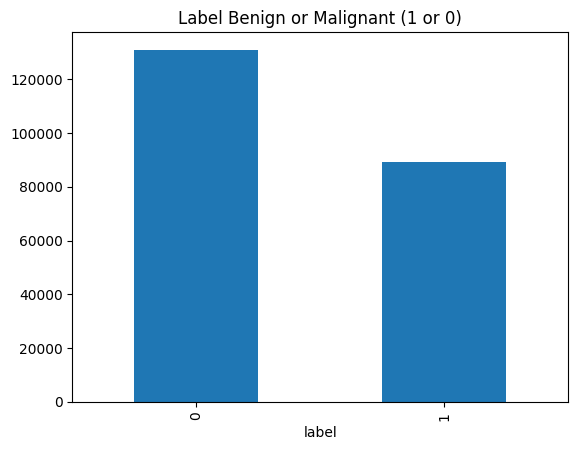

In [35]:
df_label['label'].value_counts()
df_label['label'].value_counts().plot(kind= 'bar')
plt.title('Label Benign or Malignant (1 or 0)')
plt.show()


Out of curiosity, I wanted to see what the images looked like, so here is a view of a small sample of them

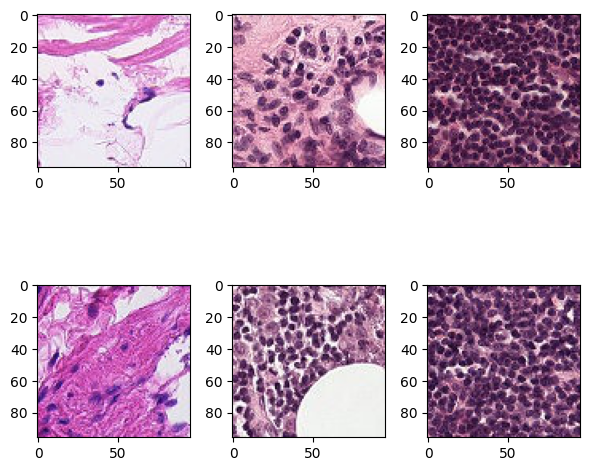

In [34]:
plt.figure(figsize = (6,6))
for i, row in enumerate(train_df.head(6).itertuples()):
  img_path = os.path.join('data/train', row.filename)
  img = load_img(img_path)
  plt.subplot(2,3,i+1)
  plt.imshow(img)
plt.tight_layout()
plt.show()

# Data Preperation

A few things must be done prior to feeding this data into a model. The first is splitting the train data into a train & validattion set. This will allow me to validate my models accuracy when modeling. I am using a 80/20 split below.

The second acction that must be performed is preparing the images for modeling. The ImageDataGenerator pre-processes the images and scales them for training. It flips and shifts them in different ways to reduce overfitting. As one can see, this is not done on the validation dataset (only rescaling is performed there).

Once these actions are complete the next step (train_model and val_model) connects the images to the actual labels in the train file.

In [7]:
train_df, val_df = train_test_split(df_label, test_size=0.2, stratify=df_label['label'], random_state=42)


In [8]:
for d in (train_df, val_df):
    d['filename'] = d['id'] + '.tif'
    d['label'] = d['label'].astype(str)

In [9]:
train_dg = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range= .03, height_shift_range = .03,
                              zoom_range = 0.1, horizontal_flip = True, vertical_flip = True)
val_dg = ImageDataGenerator(rescale = 1./255)

train_model = train_dg.flow_from_dataframe(train_df, directory = 'data/train', x_col = 'filename',y_col = 'label',
                                           target_size = (96,96), class_mode = 'binary', batch_size = 64, shuffle = True)

val_model = val_dg.flow_from_dataframe(val_df, directory = 'data/train', x_col = 'filename',y_col = 'label',
                                           target_size = (96,96), class_mode = 'binary', batch_size = 64, shuffle = False)



Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


# Model 1 (Baseline Model)

I've created two models in this notebook. The first model I ran below is simply a baseline model. I ran this model simply to experiment with the data and see what did and did not work. The second model, as will be seen further down in this notebook, uses hyperparamtization to ensure higher quality results.

## Model 1 Architecture

This baseline model has 4 convolutional blocks going from 32 to 256 with ReLU activations that capture visual features. There are max pooling layers at each block as well to control overfitting. Finally there is a dropout layer and sigmoind neuron that outputs a binary classification.

This architecture served as a standard, balanced starting point for this baseline model.

In [ ]:
def cnn_model(in_shape = (96,96,3)):
    input = keras.Input(shape = in_shape)

    x = layers.Conv2D(32, (3,3) ,activation = 'relu', padding = 'same')(input)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3) ,activation = 'relu', padding = 'same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3) ,activation = 'relu', padding = 'same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3) ,activation = 'relu', padding = 'same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation = 'relu')(x)
    x = layers.Dense(1, activation = 'sigmoid')(x)

    return keras.Model(input, x)


In [ ]:
model = cnn_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,108,033 (19.49 MB)

 Trainable params: 5,108,033 (19.49 MB)

 Non-trainable params: 0 (0.00 B)

## Model 1 (Baseline Model) Training

The below code block trains the baseline model I created using the Adam optimizer and binary cross entropy loss function. This is a standard setup for binary classification. For this initial run, I ran this model for 10 epochs.

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

hist = model.fit(train_model, epochs = 10, validation_data = val_model)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 787s 283ms/step - accuracy: 0.7631 - loss: 1.9943 - val_accuracy: 0.8019 - val_loss: 0.4327
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 679s 247ms/step - accuracy: 0.8259 - loss: 0.3960 - val_accuracy: 0.8490 - val_loss: 0.3493
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 650s 236ms/step - accuracy: 0.8444 - loss: 0.3571 - val_accuracy: 0.8340 - val_loss: 0.3730
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 652s 237ms/step - accuracy: 0.8542 - loss: 0.3384 - val_accuracy: 0.8345 - val_loss: 0.3820
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 650s 236ms/step - accuracy: 0.8667 - loss: 0.3156 - val_accuracy: 0.8651 - val_loss: 0.3204
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 719s 261ms/step - accuracy: 0.8778 - loss: 0.2949 - val_accuracy: 0.7684 - val_loss: 0.4996
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 697s 253ms/step - accuracy: 0.8792 - loss: 0.2950 - val_accuracy: 0.8140 - val_loss: 0.4237
Epoch 8/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 709s 258ms/step - ac

## Model 1 Results

The below graphs show the Training Loss, Validation Loss, Training Accuracy, and Validation Accuracty over the 10 epochs. As one can see, there is a brief dip in accuracy on the validation set around epoch 5. This can be atributed to overfitting or instability in the model. This stabalizes in the later epochs, and shows this model provides a good start that can be improved upon in Model 2.

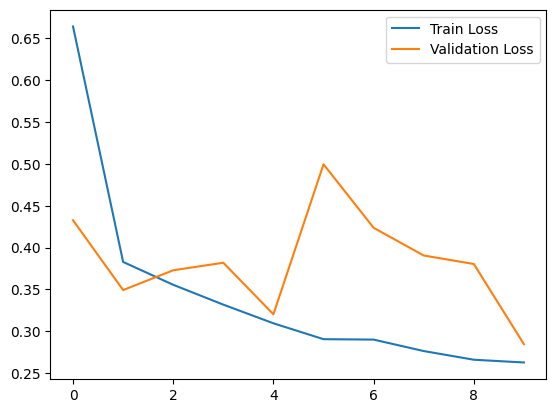

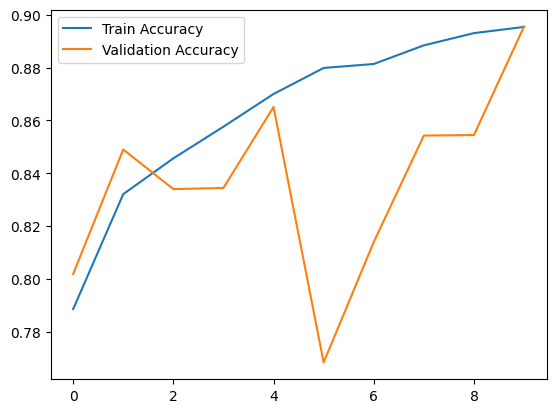

In [ ]:
plt.plot(hist.history['loss'], label = 'Train Loss')
plt.plot(hist.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label = 'Train Accuracy')
plt.plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

Below, I am simply printing the final Validation accuracy and loss.

In [ ]:
val_met = model.evaluate(val_model, verbose = 0)
print('Validation Loss is ', val_met[0])
print('Validation Accuracy is ', val_met[1])

for name, value in zip(model.metrics_names, val_met):
    print(name, ': ', value)

/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Validation Loss is  0.2846539318561554
Validation Accuracy is  0.8955573439598083
loss :  0.2846539318561554
compile_metrics :  0.8955573439598083


# Model 2- Improved Training Structure, architecture, and hyperparamater tuning on learning rate & dropout

## Model 2 Architecture

During my second experiment, on Model 2, I made a few marked improvements to increase overall accuracy.

The first improvement is to the CNN architecture. As one can see, this architecture builds on the preivous model. While it still has 4 blocks going from 32 to 256, there are some differences in each block. There is a batch normalization layer after each activation. Additionally, the dropout rate is treated as a hyperparamter, that will be changed in different runs.

The baseline model was a good place to start, but this should improve the overall accuracy of this model (and slightly decrease runtime).

In [10]:
def cnn_model2(in_shape = (96,96,3), dr = 0.5):
    input = keras.Input(shape = in_shape)

    x = layers.Conv2D(32, (3,3) , padding = 'same', use_bias = False)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3) , padding = 'same', use_bias = False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3) , padding = 'same', use_bias = False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3) , padding = 'same', use_bias = False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(dr)(x)
    x = layers.Dense(256, activation = 'relu')(x)
    x = layers.Dense(1, activation = 'sigmoid')(x)

    return keras.Model(input, x, name = f'cnn_model2_{dr}')

## Model 2 Training and Hyperparameter Tuning

The below code wraps the model training in a function, so that hyperparamater tuning can be done in the code block further down. The two features that will be tuned will be drop rate (dr) and learning rate (lr).

An additional improvement upon the previous model is that early stopping was included to stop overfitting and help save some computational time. Compute is an expensive and valuable resource on GPUs, so this is something I had to be mindful of.

This block also records validation loss, accuracy, AUC, and the best epoch ran. This is importeant to record so that I can validate which model run was the best.

In [11]:
def model2_train(lr, dr, name, train_model, val_model, max_epochs = 20):
  model2 = cnn_model2(dr = dr)

  model2.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss = 'binary_crossentropy',
                 metrics =[BinaryAccuracy(name ='accuracy'), AUC(name = 'auc')])

  stopover = callbacks.EarlyStopping(monitor = 'val_auc', patience = 2, mode = 'max', restore_best_weights = True)

  print(f'Model:{name}, Learning Rate: {lr}, Dropout: {dr}')
  hist2 = model2.fit(train_model, epochs = max_epochs, validation_data = val_model, callbacks= [stopover], verbose = 1)

  best_epoch = np.argmax(hist2.history['val_auc'])

  #val_met2 = model2.evaluate(val_model, verbose = 0)

  metricsd = {'name': name,
              'lr': lr,
              'dr': dr,
              'loss': hist2.history['val_loss'][best_epoch],
              'accuracy': hist2.history['val_accuracy'][best_epoch],
              'auc': hist2.history['val_auc'][best_epoch],
              'best_epoch': int(best_epoch + 1)
               }
  #dict(zip(model2.metrics_names, val_met2))
  #metricsd.update({'name': name, 'lr': lr, 'dr': dr})
  print("Validation Metrics for best epoch: ", metricsd )
  return model2, hist2, metricsd

The code block below calls upon the function defined above to run through three different combinations of learning rates and drop rates with the Model 2. This allows for hyperparamater tuning. One can see the different drop rates and learning rates in the search_space defined below. In the end, there are three separate runs done on model 2, each with distinct differences that will allow me to identify which paramters yield the best results

In [12]:
search_space = [{ 'lr': 1e-3, 'dr': 0.5, 'name': 'Model2, learning rate = 1e-3, dropout = 0.5'},
                {'lr': 3e-4, 'dr': 0.5, 'name': 'Model2, learning rate = 3e-4, dropout = 0.5'},
                {'lr': 3e-4, 'dr': 0.3, 'name': 'Model2, learning rate = 3e-4, dropout = 0.3'}
]

model2_runs =[]
hist2_runs = []
result2_runs = []

for c in search_space:
  m2, h2, r2 = model2_train(lr = c['lr'], dr = c['dr'], name = c['name'], train_model = train_model, val_model = val_model)
  model2_runs.append(m2)
  hist2_runs.append(h2)
  result2_runs.append(r2)



Model:Model2, learning rate = 1e-3, dropout = 0.5, Learning Rate: 0.001, Dropout: 0.5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 499s 178ms/step - accuracy: 0.8170 - auc: 0.8843 - loss: 0.5185 - val_accuracy: 0.7297 - val_auc: 0.8812 - val_loss: 0.7468
Epoch 2/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 482s 175ms/step - accuracy: 0.8764 - auc: 0.9437 - loss: 0.2961 - val_accuracy: 0.7550 - val_auc: 0.9092 - val_loss: 0.6467
Epoch 3/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 480s 174ms/step - accuracy: 0.9045 - auc: 0.9622 - loss: 0.2404 - val_accuracy: 0.6723 - val_auc: 0.7345 - val_loss: 1.2211
Epoch 4/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 481s 175ms/step - accuracy: 0.9193 - auc: 0.9711 - loss: 0.2079 - val_accuracy: 0.7578 - val_auc: 0.7601 - val_loss: 1.3804
Validation Metrics for best epoch:  {'name': 'Model2, learning rate = 1e-3, dropout = 0.5', 'lr': 0.001, 'dr': 0.5, 'loss': 0.6467090249061584, 'accuracy': 0.7550278306007385, 'auc': 0.9092324376106262, 'best_epoch': 2}
Model:Model2, learning rate = 3e-4, dropout = 0.5, Learning Rate: 0.0003, Dropout: 0.5
Epoch 1/20
2751/2751 ━━━━━━━━

## Model 2 Results

Recording the results of the Model 2 runs in a Dataframe and displaying the table of results below. As one can see, the third model run provided the best results with an accuracy of 0.912 and AUC of 0.971.

In [13]:
results2df = pd.DataFrame(result2_runs)[['name', 'lr', 'dr', 'loss', 'accuracy', 'auc', 'best_epoch']]
display(results2df)

,name,lr,dr,loss,accuracy,auc,best_epoch
0,"Model2, learning rate = 1e-3, dropout = 0.5",0.0010,0.5,0.646709,0.755028,0.909232,2
1,"Model2, learning rate = 3e-4, dropout = 0.5",0.0003,0.5,0.546067,0.819202,0.944003,4
2,"Model2, learning rate = 3e-4, dropout = 0.3",0.0003,0.3,0.246067,0.912783,0.971623,6


Now, running through the results and programatically choosing which run gave the highest accuracy, then dubbing this the "best_model"

In [14]:
bestcheck = results2df['auc'].values.argmax()
best_run = results2df.iloc[bestcheck]
print(best_run)

best_model = model2_runs[bestcheck]
best_hist = hist2_runs[bestcheck]


name          Model2, learning rate = 3e-4, dropout = 0.3
lr                                                 0.0003
dr                                                    0.3
loss                                             0.246067
accuracy                                         0.912783
auc                                              0.971623
best_epoch                                              6
Name: 2, dtype: object


After I have taken the best model, I am plotting the result to visually see the loss and accuracy through the various epochs.

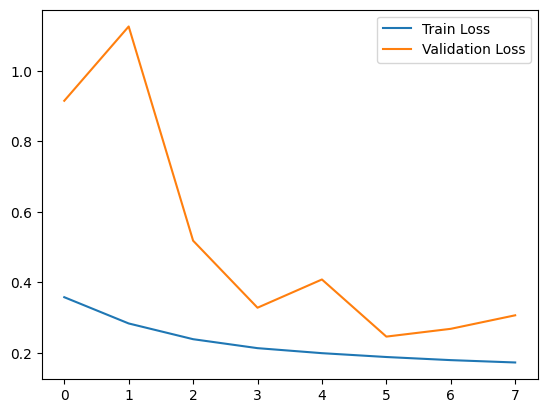

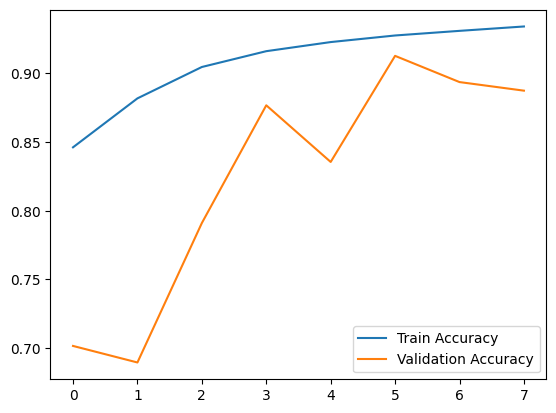

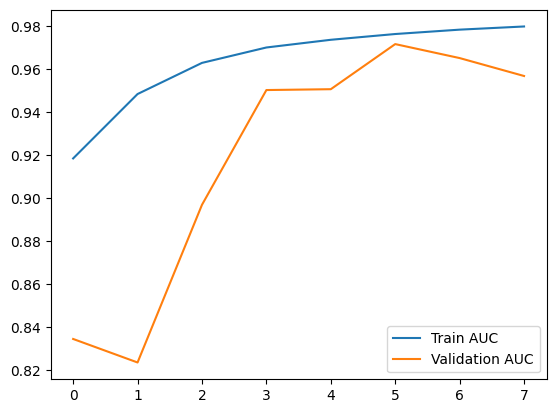

In [15]:


plt.figure()
plt.plot(best_hist.history['loss'], label = 'Train Loss')
plt.plot(best_hist.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(best_hist.history['accuracy'], label = 'Train Accuracy')
plt.plot(best_hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(best_hist.history['auc'], label = 'Train AUC')
plt.plot(best_hist.history['val_auc'], label = 'Validation AUC')
plt.legend()
plt.show()

# Discussion of Results & Conclusion

As one can see, the baseline model provided a solid foundational result for this project. It acheived a validation accuraccy of 0.89, which is a strong first result. Once the model was improved in model 2 through hyperparameter tuning, improved architecture, and improved training strategy, it gave a much better result. With a final accuracy of 0.91 and AUC of 0.97, this final model provided a strong submission for the kaggle competition.

One limitation that should be noted for this project was the availability of free GPU resources. Google colab was used for this, and paid for at the base tier, but this project could be improved more quickly and easily if better GPU resources were provided.

## Generating Submission File

Finally I am taking the results and applying them to the test data. After this, these results are put into a submission file for the Kaggle competions

In [23]:
sample_sub = pd.read_csv('data/sample_submission.csv')
sample_sub['filename'] = sample_sub['id'] + '.tif'
sample_sub.head()

,id,label,filename
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [29]:
test_dg = ImageDataGenerator(rescale = 1./255)

test_model = test_dg.flow_from_dataframe(dataframe = sample_sub, directory = 'data/test', x_col = 'filename', y_col = None,
                                         target_size = (96,96), class_mode = None, batch_size = 64, shuffle = False)

test_model.reset()
y_pred = best_model.predict(test_model,verbose = 1).ravel()
#y_pred = y_pred.reshape(-1)

print(y_pred.min(), y_pred.max(), y_pred.mean())

sample_sub['label'] = y_pred.astype(float)

print(sample_sub.head())
print(sample_sub['label'].describe())

sample_sub[['id', 'label']].to_csv('submission.csv', index = False)
print('Saved')

Found 57458 validated image filenames.
  1/898 ━━━━━━━━━━━━━━━━━━━━ 1:01 68ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step
1.0916642e-12 0.99999964 0.28193107
                                         id     label  \
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5  0.013871   
1  95596b92e5066c5c52466c90b69ff089b39f2737  0.052331   
2  248e6738860e2ebcf6258cdc1f32f299e0c76914  0.000224   
3  2c35657e312966e9294eac6841726ff3a748febf  0.028357   
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6  0.009697   

                                       filename  
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif  
1  95596b92e5066c5c52466c90b69ff089b39f2737.tif  
2  248e6738860e2ebcf6258cdc1f32f299e0c76914.tif  
3  2c35657e312966e9294eac6841726ff3a748febf.tif  
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif  
count    5.745800e+04
mean     2.819311e-01
std      3.789060e-01
min      1.091664e-12
25%      2.438782e-03
50%      3.053420e-02
75%      6.229630e-01
max      9.999996e-01
Name: label, dtype: float64
Saved


In [30]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# References

[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

[2] Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

[3] OpenAI. (2025). ChatGPT (version GPT-5) [Large language model]. OpenAI. (Used for error trace debugging and function usage examples.)

[4] Google DeepMind. (2025). Gemini [Large language model]. Google DeepMind. (Used for error trace debugging and function usage examples.)

[5] TensorFlow Tutorials. (2024, August 16). Convolutional neural network (CNN) | TensorFlow Core. Retrieved November 12, 2025, from https://www.tensorflow.org/tutorials/images/cnn

[6] Ndum, A. (2020, December 8). Batch norm explained visually — how it works and why neural networks need it. Towards Data Science. Retrieved November 12, 2025, from https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739/